<h1 align = "center"><b> XGBoost </b></h1>

&emsp;&emsp; Nesta etapa, vamos analisar e transformar os dados para que possamos aplicar o modelo XGBoost.

In [38]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [262]:
df = pd.read_csv('../Demanda Diária.csv', index_col = 0, parse_dates = True)
df = df.loc[df['loja'] == 1]
df = df.loc[df['produto'] == 1]
df = df.drop(['loja', 'produto'], axis = 1)

<h2 align = "center"><b> Desmembrando a Data </b></h2>

In [263]:
def DesmembrarData (df):
    df['Dia'] = df.index.day
    df['Mês'] = df.index.month
    df['Ano'] = df.index.year
    df['Dia_da_Semana'] = df.index.dayofweek + 2 # Domingo = 1
    df['Dia_do_Ano'] = df.index.dayofyear
    df['Fim_de_Semana'] = df['Dia_da_Semana'].map(lambda x: True if x > 6 else False)
    df['start_of_month'] = df.index.is_month_start.astype(int)
    df['end_of_month'] = df.index.is_month_end.astype(int)

    br_holidays = holidays.Brazil()
    df['Feriado'] = df.index.map(lambda x: True if x in br_holidays else False)

    df = pd.get_dummies(df, columns = ['Dia', 'Mês', 'Ano', 'Dia_da_Semana'])     
    
    return df

In [264]:
df = DesmembrarData(df)

<h2 align = "center"><b> Desmembrando o Número de Vendas </b></h2>

In [267]:
def CriarLags (df):
    Lista_Lags = [1, 2, 3, 4, 5, 6, 7, 30, 61, 91, 182, 365] # Ultima semana, 1 mês, 2 meses, 3 meses, 6 meses, 1 ano, 2 anos
    for i in Lista_Lags:
        df['Lag_' + str(i)] = df['itens_vendidos'].shift(i) # Lag = Atraso, é o valor da variável em um determinado período de tempo anterior
    return df

def CriarMédiasMóveis (df):
    Janelas = [7, 30, 61, 365]  # 1 semana, 1 mês, 2 meses, 1 ano
    for i in Janelas:
        df['Media_Movel_' + str(i)] = df['itens_vendidos'].rolling(i).mean()
        df['EWM_' + str(i)] = df['itens_vendidos'].ewm(span = i).mean() # Média Móvel Ponderada Exponencialmente
    return df

In [268]:
df = CriarLags(df)
df = CriarMédiasMóveis(df)

<h2 align = "center"><b> Criando o Modelo XGBoost </b></h2>

In [269]:
X_treino = df.iloc[:-31].drop('itens_vendidos', axis = 1)
X_teste = df.iloc[-31:].drop('itens_vendidos', axis = 1)
y_treino = df.iloc[:-31]['itens_vendidos']
y_teste = df.iloc[-31:]['itens_vendidos']

from sklearn.model_selection import train_test_split
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size = 0.25, random_state = 1)

In [270]:
import xgboost as xgb
modelo = xgb.XGBRegressor()

In [271]:
modelo.fit(X_treino, y_treino, eval_set = [(X_val, y_val)], verbose = True, eval_metric = 'rmse', early_stopping_rounds = 20)

[0]	validation_0-rmse:4.98404
[1]	validation_0-rmse:4.23684
[2]	validation_0-rmse:3.71603
[3]	validation_0-rmse:3.38999
[4]	validation_0-rmse:3.19020
[5]	validation_0-rmse:3.02936
[6]	validation_0-rmse:2.90947


c:\Users\Atual\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Atual\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:2.85096
[8]	validation_0-rmse:2.78453
[9]	validation_0-rmse:2.74579
[10]	validation_0-rmse:2.68882
[11]	validation_0-rmse:2.63537
[12]	validation_0-rmse:2.61070
[13]	validation_0-rmse:2.59223
[14]	validation_0-rmse:2.56634
[15]	validation_0-rmse:2.54743
[16]	validation_0-rmse:2.51377
[17]	validation_0-rmse:2.51034
[18]	validation_0-rmse:2.50167
[19]	validation_0-rmse:2.47579
[20]	validation_0-rmse:2.44934
[21]	validation_0-rmse:2.43844
[22]	validation_0-rmse:2.43105
[23]	validation_0-rmse:2.41944
[24]	validation_0-rmse:2.41032
[25]	validation_0-rmse:2.39443
[26]	validation_0-rmse:2.37951
[27]	validation_0-rmse:2.37617
[28]	validation_0-rmse:2.37541
[29]	validation_0-rmse:2.36783
[30]	validation_0-rmse:2.36359
[31]	validation_0-rmse:2.36431
[32]	validation_0-rmse:2.35438
[33]	validation_0-rmse:2.35055
[34]	validation_0-rmse:2.34901
[35]	validation_0-rmse:2.34345
[36]	validation_0-rmse:2.34153
[37]	validation_0-rmse:2.33861
[38]	validation_0-rmse:2.33881
[39]	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [272]:
previsoes = modelo.predict(X_teste)
previsoes = pd.DataFrame(previsoes, index = X_teste.index)

In [273]:
resultado = pd.concat([y_teste, previsoes], axis = 1)
resultado.columns = ['Valor Real', 'Previsão']

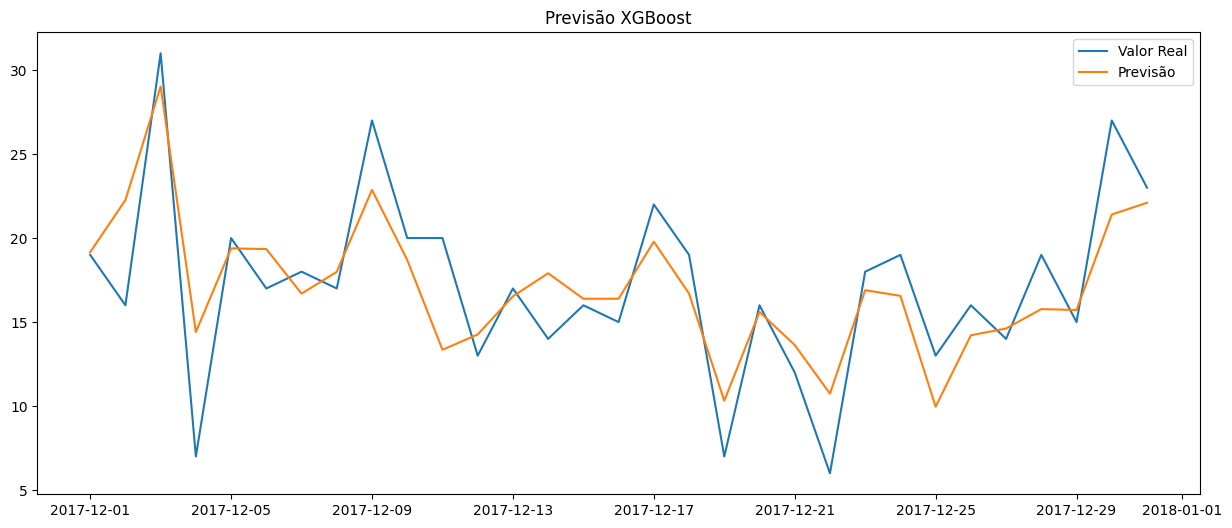

In [274]:
plt.plot(resultado['Valor Real'], label = 'Valor Real')
plt.plot(resultado['Previsão'], label = 'Previsão')
plt.legend(loc = 'best')
plt.title('Previsão XGBoost')
plt.show()

In [275]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('RMSE: ', mean_squared_error(resultado['Valor Real'], resultado['Previsão'], squared = False))
print('MAE: ', mean_absolute_error(resultado['Valor Real'], resultado['Previsão']))

RMSE:  3.101893982119906
MAE:  2.406527273116573
